### Question 1.
Perform experiments that show that BatchNorm can    
(a) accelerate convergence of gradientbased neural network training algorithms,  
(b) can permit larger learning rates, and   
(c) can lead to betterneural network performance. You may select any context you like for your experiments.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(40)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


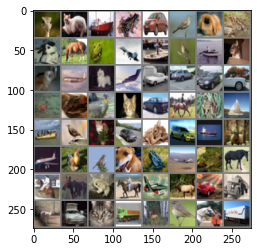

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
class ConvNet(nn.Module):
    def __init__(self, apply_bn=False):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.apply_bn = apply_bn
        

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.conv1(x)
        
        if self.apply_bn == True:
            x = self.bn1(x)
            
        x = self.pool(F.relu(x))              # -> n, 6, 14, 14
        x = self.conv2(x)
        
        if self.apply_bn == True:
            x = self.bn2(x)
        
        x = self.pool(F.relu(x))              # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x



In [5]:
def get_accuracy(outputs, labels):
    
    _, predicted = torch.max(outputs, 1)
    n_samples = labels.size(0)
    n_correct = (predicted == labels).sum().item()
    accuracy = (n_correct * 100)/n_samples
    
    return accuracy


def do_eval(data_loader, model):
    model.eval()
    eval_loss = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():

        # creating empty tensors
        output_list = torch.Tensor()
        label_list = torch.Tensor()
        
        for images, labels in data_loader:
            outputs = model(images)
            
            output_list = torch.cat((output_list, outputs), 0)
            label_list = torch.cat((label_list,labels), 0)
            
            loss = criterion(outputs, labels)
            eval_loss.append(loss.item())
                
        acc = get_accuracy(output_list, label_list)
        eval_loss = sum(eval_loss)/len(eval_loss)
        
    return acc, eval_loss


In [6]:
def train_model(model, lr=0.001, num_epochs=30, train_log_freq=100):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_accuracy = []
    test_accuracy = []
    train_epoch_loss = []
    test_epoch_loss = []
    train_loss = []
    n_total_steps = len(train_loader)


    for epoch in range(num_epochs):
        model.train()
        total_loss = []

        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss.append(loss.item())

            if i % train_log_freq == 0:
                train_loss.append(sum(total_loss)/len(total_loss))
                total_loss = []

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc, epoch_loss_train = do_eval(train_loader, model)
        train_epoch_loss.append(epoch_loss_train)
        train_accuracy.append(train_acc)
        print (f'Epoch [{epoch+1}], Train accuracy [{train_acc}], Train loss [{epoch_loss_train}]')

        test_acc, epoch_loss_test = do_eval(test_loader, model)
        test_epoch_loss.append(epoch_loss_test)
        test_accuracy.append(test_acc)
        print (f'Epoch [{epoch+1}], Test accuracy: [{test_acc}], Test loss: [{epoch_loss_test}]')
        
    return train_epoch_loss, train_accuracy, test_epoch_loss, test_accuracy



In [7]:
train_epoch_loss1, train_accuracy1, test_epoch_loss1, test_accuracy1 = train_model(ConvNet())

Epoch [1], Train accuracy [10.0], Train loss [2.3031027740834618]
Epoch [1], Test accuracy: [10.0], Test loss: [2.303097049142145]
Epoch [2], Train accuracy [10.002], Train loss [2.302693002669098]
Epoch [2], Test accuracy: [10.0], Test loss: [2.3026814065921077]
Epoch [3], Train accuracy [10.006], Train loss [2.302283128814014]
Epoch [3], Test accuracy: [10.0], Test loss: [2.3022673479311027]
Epoch [4], Train accuracy [10.016], Train loss [2.3018345037079833]
Epoch [4], Test accuracy: [10.0], Test loss: [2.3018302097442045]
Epoch [5], Train accuracy [10.026], Train loss [2.3013478026670566]
Epoch [5], Test accuracy: [10.01], Test loss: [2.301351125073281]
Epoch [6], Train accuracy [10.028], Train loss [2.3007789142906208]
Epoch [6], Test accuracy: [10.01], Test loss: [2.300798047120404]
Epoch [7], Train accuracy [10.056], Train loss [2.3000911760818012]
Epoch [7], Test accuracy: [10.07], Test loss: [2.3001277401189135]
Epoch [8], Train accuracy [10.136], Train loss [2.29921070815962]


In [8]:
train_epoch_loss2, train_accuracy2, test_epoch_loss2, test_accuracy2 = train_model(ConvNet(apply_bn=True))

Epoch [1], Train accuracy [17.794], Train loss [2.2692511087793217]
Epoch [1], Test accuracy: [17.59], Test loss: [2.268874052983181]
Epoch [2], Train accuracy [21.98], Train loss [2.2232873686744123]
Epoch [2], Test accuracy: [21.9], Test loss: [2.2223194921092624]
Epoch [3], Train accuracy [25.706], Train loss [2.143028985203989]
Epoch [3], Test accuracy: [26.2], Test loss: [2.1417722246449467]
Epoch [4], Train accuracy [29.422], Train loss [2.0191262239385446]
Epoch [4], Test accuracy: [29.85], Test loss: [2.0175946958505424]
Epoch [5], Train accuracy [33.418], Train loss [1.890112247308502]
Epoch [5], Test accuracy: [33.78], Test loss: [1.8869807150713198]
Epoch [6], Train accuracy [35.37], Train loss [1.806242891894582]
Epoch [6], Test accuracy: [36.02], Test loss: [1.802574629236938]
Epoch [7], Train accuracy [37.218], Train loss [1.7487466207245732]
Epoch [7], Test accuracy: [38.0], Test loss: [1.7461557479421044]
Epoch [8], Train accuracy [37.406], Train loss [1.718492935533109

In [9]:
train_epoch_loss3, train_accuracy3, test_epoch_loss3, test_accuracy3 = train_model(ConvNet(), lr=0.01)

Epoch [1], Train accuracy [15.102], Train loss [2.289364580912968]
Epoch [1], Test accuracy: [15.42], Test loss: [2.288981102074787]
Epoch [2], Train accuracy [27.232], Train loss [1.9897379584019752]
Epoch [2], Test accuracy: [27.85], Test loss: [1.9775925540620354]
Epoch [3], Train accuracy [32.488], Train loss [1.8755720018425865]
Epoch [3], Test accuracy: [32.9], Test loss: [1.86036439761994]
Epoch [4], Train accuracy [37.836], Train loss [1.6665575563755182]
Epoch [4], Test accuracy: [38.23], Test loss: [1.6576707613695958]
Epoch [5], Train accuracy [41.068], Train loss [1.5895346041835483]
Epoch [5], Test accuracy: [41.08], Test loss: [1.583855691229462]
Epoch [6], Train accuracy [42.184], Train loss [1.5713550219755343]
Epoch [6], Test accuracy: [41.45], Test loss: [1.5723075502237696]
Epoch [7], Train accuracy [41.528], Train loss [1.68076929244239]
Epoch [7], Test accuracy: [41.78], Test loss: [1.6797817915108553]
Epoch [8], Train accuracy [36.99], Train loss [1.82314082499965

In [10]:
train_epoch_loss4, train_accuracy4, test_epoch_loss4, test_accuracy4 = train_model(ConvNet(apply_bn=True), lr=0.01)

Epoch [1], Train accuracy [38.934], Train loss [1.6537059923572004]
Epoch [1], Test accuracy: [38.93], Test loss: [1.652234509492376]
Epoch [2], Train accuracy [41.632], Train loss [1.6055837726349111]
Epoch [2], Test accuracy: [41.77], Test loss: [1.6034997724423743]
Epoch [3], Train accuracy [49.492], Train loss [1.4189968987194168]
Epoch [3], Test accuracy: [48.94], Test loss: [1.4221032979382071]
Epoch [4], Train accuracy [48.378], Train loss [1.4998133664240922]
Epoch [4], Test accuracy: [47.7], Test loss: [1.5106358156082735]
Epoch [5], Train accuracy [51.416], Train loss [1.3355592238476208]
Epoch [5], Test accuracy: [50.37], Test loss: [1.3533564566806624]
Epoch [6], Train accuracy [58.852], Train loss [1.1502600476107634]
Epoch [6], Test accuracy: [56.92], Test loss: [1.187379238332153]
Epoch [7], Train accuracy [45.92], Train loss [1.595476513476018]
Epoch [7], Test accuracy: [44.32], Test loss: [1.6342416139924603]
Epoch [8], Train accuracy [42.438], Train loss [1.7170858221

In [27]:
train_epoch_loss5, train_accuracy5, test_epoch_loss5, test_accuracy5 = train_model(ConvNet(), lr=0.1)

Epoch [1], Train accuracy [40.17], Train loss [1.633765536348533]
Epoch [1], Test accuracy: [39.86], Test loss: [1.6453472041780022]
Epoch [2], Train accuracy [45.104], Train loss [1.596961625701631]
Epoch [2], Test accuracy: [44.74], Test loss: [1.6149902867663437]
Epoch [3], Train accuracy [50.962], Train loss [1.3809603079200705]
Epoch [3], Test accuracy: [49.2], Test loss: [1.4391073649096642]
Epoch [4], Train accuracy [57.212], Train loss [1.2082724250338572]
Epoch [4], Test accuracy: [54.54], Test loss: [1.3015726542776558]
Epoch [5], Train accuracy [54.99], Train loss [1.269008315813816]
Epoch [5], Test accuracy: [51.84], Test loss: [1.3771168077067963]
Epoch [6], Train accuracy [65.678], Train loss [0.9588242858419638]
Epoch [6], Test accuracy: [60.15], Test loss: [1.1326954778592297]
Epoch [7], Train accuracy [66.504], Train loss [0.9393223223021573]
Epoch [7], Test accuracy: [58.62], Test loss: [1.178203621108061]
Epoch [8], Train accuracy [67.514], Train loss [0.915422344451

In [28]:
train_epoch_loss6, train_accuracy6, test_epoch_loss6, test_accuracy6 = train_model(ConvNet(apply_bn=True), lr=0.1)


Epoch [1], Train accuracy [43.232], Train loss [1.6320071523756627]
Epoch [1], Test accuracy: [42.94], Test loss: [1.6337137973991929]
Epoch [2], Train accuracy [53.302], Train loss [1.3095502327470219]
Epoch [2], Test accuracy: [51.8], Test loss: [1.349077427463167]
Epoch [3], Train accuracy [57.698], Train loss [1.1639312322029982]
Epoch [3], Test accuracy: [54.73], Test loss: [1.2428126870446903]
Epoch [4], Train accuracy [51.722], Train loss [1.5233969423167235]
Epoch [4], Test accuracy: [49.18], Test loss: [1.605513231010194]
Epoch [5], Train accuracy [62.312], Train loss [1.074401258812536]
Epoch [5], Test accuracy: [58.25], Test loss: [1.216884428908111]
Epoch [6], Train accuracy [64.658], Train loss [0.985468601784133]
Epoch [6], Test accuracy: [59.59], Test loss: [1.1440326248764232]
Epoch [7], Train accuracy [65.332], Train loss [0.9774299484232197]
Epoch [7], Test accuracy: [59.64], Test loss: [1.1863903479211648]
Epoch [8], Train accuracy [56.042], Train loss [1.36330382567

In [31]:
train_epoch_loss7, train_accuracy7, test_epoch_loss7, test_accuracy7 = train_model(ConvNet(), lr=0.5)

Epoch [1], Train accuracy [27.842], Train loss [2.103448271294079]
Epoch [1], Test accuracy: [27.59], Test loss: [2.1087929944323887]
Epoch [2], Train accuracy [37.514], Train loss [1.6673538982105987]
Epoch [2], Test accuracy: [37.0], Test loss: [1.6914878643242417]
Epoch [3], Train accuracy [40.654], Train loss [1.6928873400554023]
Epoch [3], Test accuracy: [39.45], Test loss: [1.732147395231162]
Epoch [4], Train accuracy [45.04], Train loss [1.6031619683860818]
Epoch [4], Test accuracy: [43.62], Test loss: [1.6667759304593324]
Epoch [5], Train accuracy [40.442], Train loss [1.8962825321785324]
Epoch [5], Test accuracy: [38.91], Test loss: [1.9724570239425465]
Epoch [6], Train accuracy [46.61], Train loss [1.5318683399568738]
Epoch [6], Test accuracy: [43.83], Test loss: [1.6096390318718685]
Epoch [7], Train accuracy [44.238], Train loss [1.5523359854812817]
Epoch [7], Test accuracy: [42.1], Test loss: [1.6307241590159713]
Epoch [8], Train accuracy [38.5], Train loss [2.0839943167803

In [32]:
train_epoch_loss8, train_accuracy8, test_epoch_loss8, test_accuracy8 = train_model(ConvNet(apply_bn=True), lr=0.5)

Epoch [1], Train accuracy [43.976], Train loss [1.513376418586887]
Epoch [1], Test accuracy: [42.37], Test loss: [1.5590547444714102]
Epoch [2], Train accuracy [50.32], Train loss [1.407875024068081]
Epoch [2], Test accuracy: [48.08], Test loss: [1.4840688166345002]
Epoch [3], Train accuracy [50.628], Train loss [1.3674964051874703]
Epoch [3], Test accuracy: [48.05], Test loss: [1.4572742919253696]
Epoch [4], Train accuracy [35.302], Train loss [2.2160111135229124]
Epoch [4], Test accuracy: [35.08], Test loss: [2.2536961660263644]
Epoch [5], Train accuracy [63.77], Train loss [1.0306761123792594]
Epoch [5], Test accuracy: [58.76], Test loss: [1.1934648228299087]
Epoch [6], Train accuracy [59.616], Train loss [1.117127859531461]
Epoch [6], Test accuracy: [54.83], Test loss: [1.3042490592428073]
Epoch [7], Train accuracy [64.14], Train loss [1.0108566121067233]
Epoch [7], Test accuracy: [58.46], Test loss: [1.2448264705907008]
Epoch [8], Train accuracy [60.382], Train loss [1.11144462708

In [36]:
train_epoch_loss9, train_accuracy9, test_epoch_loss9, test_accuracy9 = train_model(ConvNet(), lr=1)

Epoch [1], Train accuracy [16.256], Train loss [2.3854110390328995]
Epoch [1], Test accuracy: [16.77], Test loss: [2.378195029155464]
Epoch [2], Train accuracy [26.298], Train loss [1.9723580090895942]
Epoch [2], Test accuracy: [26.9], Test loss: [1.967588584134533]
Epoch [3], Train accuracy [26.118], Train loss [2.0043261455148076]
Epoch [3], Test accuracy: [26.26], Test loss: [2.0175111331757467]
Epoch [4], Train accuracy [24.774], Train loss [1.9847160222585245]
Epoch [4], Test accuracy: [25.04], Test loss: [1.9911221167084519]
Epoch [5], Train accuracy [29.388], Train loss [1.9408789339577754]
Epoch [5], Test accuracy: [29.33], Test loss: [1.9431099109588914]
Epoch [6], Train accuracy [25.602], Train loss [2.021138501746575]
Epoch [6], Test accuracy: [25.07], Test loss: [2.018463407352472]
Epoch [7], Train accuracy [31.472], Train loss [1.8473795891722755]
Epoch [7], Test accuracy: [31.09], Test loss: [1.8719453416812193]
Epoch [8], Train accuracy [31.158], Train loss [1.8372591066

In [37]:
train_epoch_loss10, train_accuracy10, test_epoch_loss10, test_accuracy10 = train_model(ConvNet(apply_bn=True), lr=1)

Epoch [1], Train accuracy [37.876], Train loss [1.9687269570882364]
Epoch [1], Test accuracy: [37.2], Test loss: [1.9963436612657681]
Epoch [2], Train accuracy [40.732], Train loss [1.6780625487227574]
Epoch [2], Test accuracy: [39.74], Test loss: [1.716748384153767]
Epoch [3], Train accuracy [34.204], Train loss [2.365387661377792]
Epoch [3], Test accuracy: [33.91], Test loss: [2.4197612325097344]
Epoch [4], Train accuracy [48.694], Train loss [1.525158632365639]
Epoch [4], Test accuracy: [47.11], Test loss: [1.6143546719459971]
Epoch [5], Train accuracy [53.218], Train loss [1.3147390080077568]
Epoch [5], Test accuracy: [49.9], Test loss: [1.4211619226795853]
Epoch [6], Train accuracy [49.658], Train loss [1.4626378635006487]
Epoch [6], Test accuracy: [46.95], Test loss: [1.5768343559495963]
Epoch [7], Train accuracy [43.774], Train loss [1.705918972601976]
Epoch [7], Test accuracy: [41.67], Test loss: [1.8179845179721807]
Epoch [8], Train accuracy [50.782], Train loss [1.69279907091

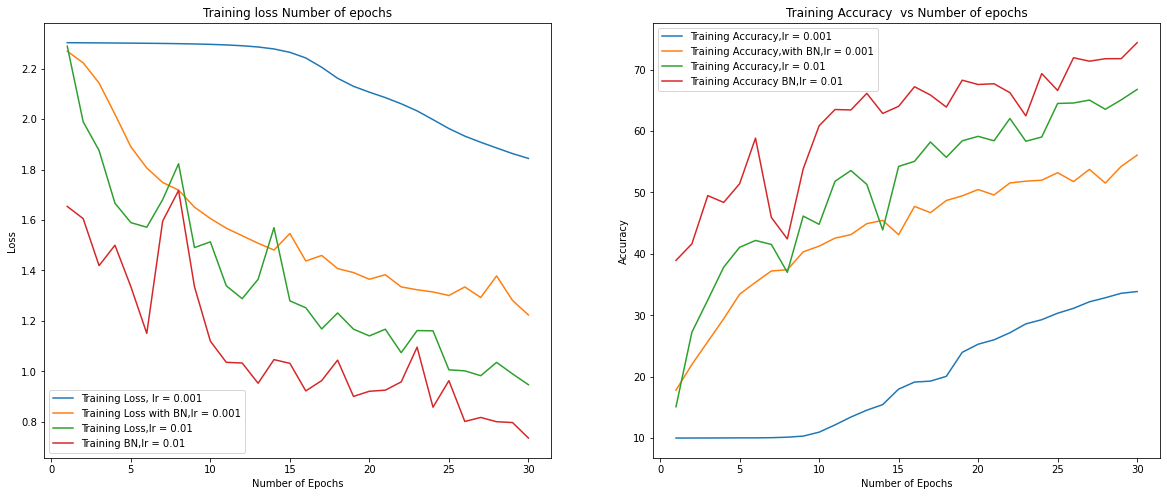

In [26]:
# plotting the training losses over iteration

fig = plt.figure(1,figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_epoch_loss1)+1), train_epoch_loss1, label = "Training Loss, lr = 0.001 ")
plt.plot(range(1, len(train_epoch_loss2)+1), train_epoch_loss2, label = "Training Loss with BN,lr = 0.001")
plt.plot(range(1, len(train_epoch_loss3)+1), train_epoch_loss3, label = "Training Loss,lr = 0.01")
plt.plot(range(1, len(train_epoch_loss4)+1), train_epoch_loss4, label = "Training BN,lr = 0.01")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training loss Number of epochs')
plt.legend()

# plotting the training accuracies over iterationa
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracy1)+1), train_accuracy1, label = "Training Accuracy,lr = 0.001 ")
plt.plot(range(1, len(train_accuracy2)+1), train_accuracy2, label = "Training Accuracy,with BN,lr = 0.001")
plt.plot(range(1, len(train_accuracy3)+1), train_accuracy3, label = "Training Accuracy,lr = 0.01")
plt.plot(range(1, len(train_accuracy4)+1), train_accuracy4, label = "Training Accuracy BN,lr = 0.01")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy  vs Number of epochs')
plt.legend()
plt.show()

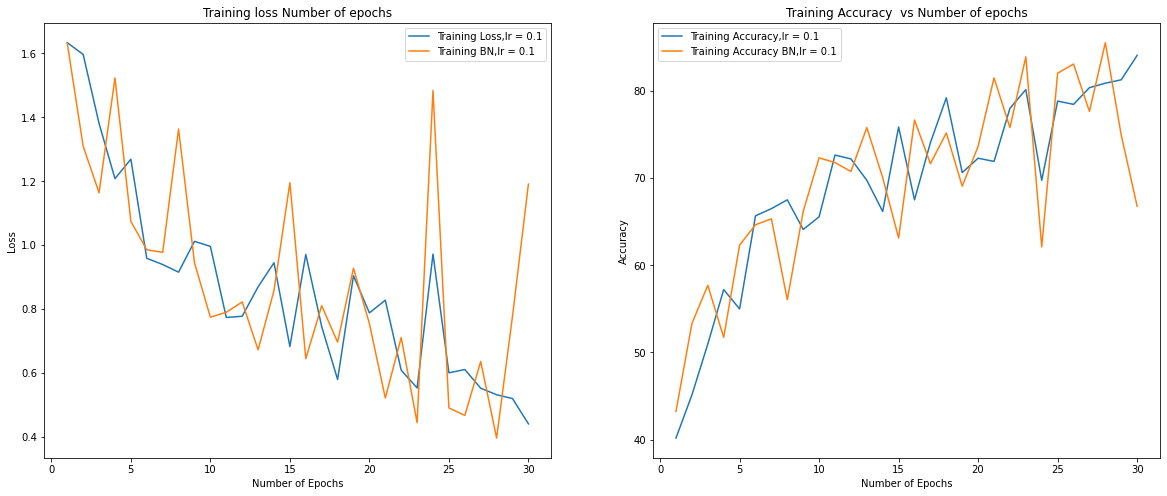

In [30]:
# plotting the training losses over iteration

fig = plt.figure(1,figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_epoch_loss5)+1), train_epoch_loss5, label = "Training Loss,lr = 0.1")
plt.plot(range(1, len(train_epoch_loss6)+1), train_epoch_loss6, label = "Training BN,lr = 0.1")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training loss Number of epochs')
plt.legend()

# plotting the training accuracies over iterationa
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracy5)+1), train_accuracy5, label = "Training Accuracy,lr = 0.1")
plt.plot(range(1, len(train_accuracy6)+1), train_accuracy6, label = "Training Accuracy BN,lr = 0.1")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy  vs Number of epochs')
plt.legend()
plt.show()

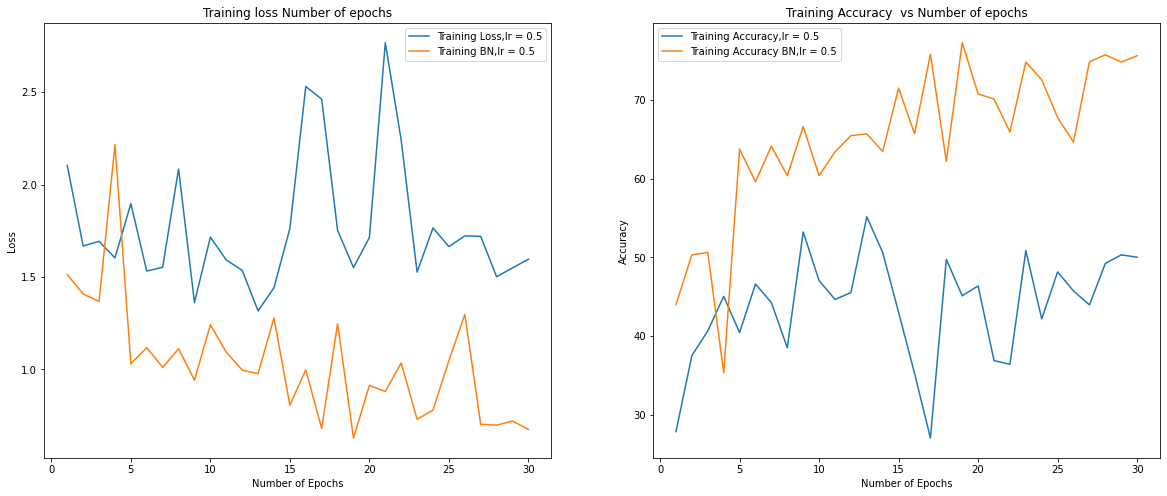

In [33]:
# plotting the training losses over iteration

fig = plt.figure(1,figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_epoch_loss7)+1), train_epoch_loss7, label = "Training Loss,lr = 0.5")
plt.plot(range(1, len(train_epoch_loss8)+1), train_epoch_loss8, label = "Training BN,lr = 0.5")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training loss Number of epochs')
plt.legend()

# plotting the training accuracies over iterationa
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracy7)+1), train_accuracy7, label = "Training Accuracy,lr = 0.5")
plt.plot(range(1, len(train_accuracy8)+1), train_accuracy8, label = "Training Accuracy BN,lr = 0.5")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy  vs Number of epochs')
plt.legend()
plt.show()

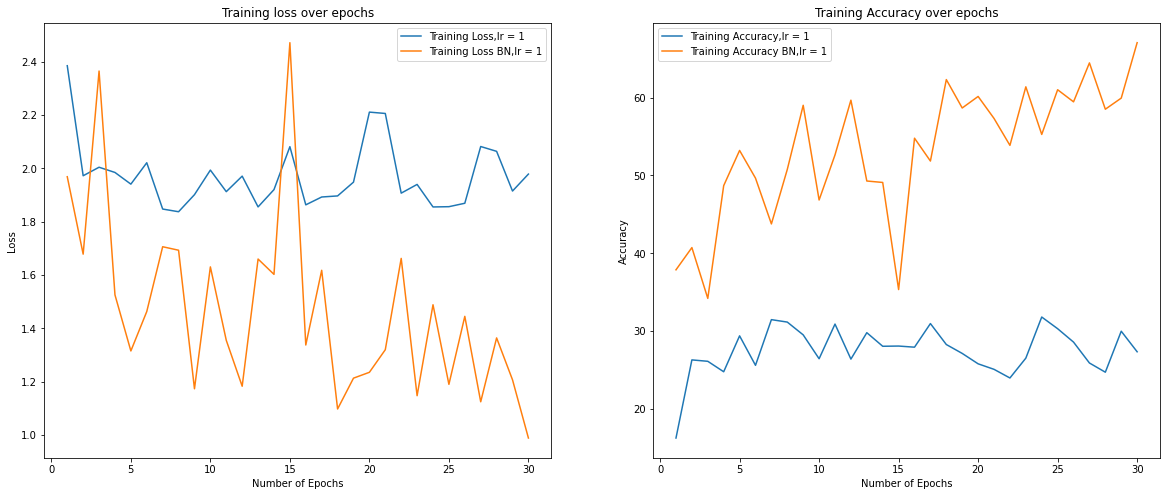

In [39]:
# plotting the training losses over iteration

fig = plt.figure(1,figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_epoch_loss9)+1), train_epoch_loss9, label = "Training Loss,lr = 1")
plt.plot(range(1, len(train_epoch_loss10)+1), train_epoch_loss10, label = "Training Loss BN,lr = 1")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training loss over epochs')
plt.legend()

# plotting the training accuracies over iterationa
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracy9)+1), train_accuracy9, label = "Training Accuracy,lr = 1")
plt.plot(range(1, len(train_accuracy10)+1), train_accuracy10, label = "Training Accuracy BN,lr = 1")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over epochs')
plt.legend()
plt.show()